In [1]:
import pysm3
from pysm3 import InterpolatingComponent, Model, units as u, utils
import numpy as np
import os
import healpy as hp
import warnings
import matplotlib.pyplot as plt
from past.utils import old_div

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
os.environ["PYSM_LOCAL_DATA"] = "/"
DEFAULT_TCMB = 2.726
H_CGS = 6.62608e-27
K_CGS = 1.3806488e-16
C_light = 2.99792e+10

"""
    Class Hierarchy 
    mmDLHelper
    Model -> mmDLModel
    InterpolatingComponent -> mmDLInterpolatingComponent -> mmDLInterpolatingComponentIdentity (for freq indep compts)
                                                         -> mmDLInterpolatingComponentTSZ (for TSZ)
                                                         -> mmDLInterpolatingComponentPTSource (for CIB and Radio Pt Sources)
"""


class mmDLHelper(object):
    """
        A simple helper to keep track of file names/input frequency and etc...
    """
    def __init__(self, path):
        self.path = path ## root directory for mmdl 
        self.freqs = [30, 90, 148, 219, 277, 350]
        self.compts = ["lensed_cmb", "kappa", "ksz", "tsz", "rad_pts", "ir_pts"]
        self.input_units = u.uK_CMB
        
    def get_path(self, sim_idx):
        return self.path
    
    def get_file_name(self, compt_idx, sim_idx, freq=None, polidx=None):
        if compt_idx in ["tsz", "rad_pts", "ir_pts"]:
            assert(freq in self.freqs)
            f = os.path.join(self.path, f"{sim_idx:05d}/{compt_idx}_{freq:03d}ghz_{sim_idx:05d}.fits")
        elif compt_idx in ["kappa", "ksz"]:
            f = os.path.join(self.path, f"{sim_idx:05d}/{compt_idx}_{sim_idx:05d}.fits")
        elif compt_idx in ["lensed_cmb"]:
            assert(polidx in ["T","Q","U"])
            f = os.path.join(self.path, f"{sim_idx:05d}/{compt_idx}_{polidx}_{sim_idx:05d}.fits")
        elif compt_idx in ["combined"]:
            assert(freq in self.freqs)
            assert(polidx in ["T","Q","U"])
            f = os.path.join(self.path, f"{sim_idx:05d}/{compt_idx}_{polidx}_{freq:03d}ghz_{sim_idx:05d}.fits")
        else:
            raise NotImplemented()
        return f 
    
    def fnu(self, nu, tcmb=DEFAULT_TCMB):
        """
        nu in GHz
        tcmb in Kelvin
        """
        nu = np.asarray(nu)
        mu = H_CGS * (1e9 * nu) / (K_CGS * tcmb)
        ans = mu / np.tanh(old_div(mu, 2.0)) - 4.0
        return ans

    
class mmDLModel(Model):
    def __init__(
        self,
        path,
        map_dist=None,
        verbose=False,
    ):        
        self.path = path ## root directory for mmdl
        self.map_dist = map_dist
        self.verbose = verbose
        self.mmdl_helper = mmDLHelper(self.path)
        
        ## fixed for now
        self.nside = 4096 ## HEALPix NSIDE of the output maps
        self.interpolation_kind = "linear" ## dummy string
        self.freq_independent_compts = ["lensed_cmb_t", "lensed_cmb_q", "lensed_cmb_u", "kappa", "ksz"]
        self.freq_dependent_compts = ["tsz", "rad_pts", "ir_pts"]
        
        self.interpolators = {}
        
    def clean_cached(self):
        for item in self.interpolators:
            item.cached_maps.clear()
        del self.interpolators
        self.interpolators = {}
    
    def get_interpolators(self, sim_idx):
        if sim_idx not in self.interpolators:
            self.interpolators[sim_idx] = {}

            ## these components are frequency independent. 
            for compt_idx in ["lensed_cmb_t", "lensed_cmb_q", "lensed_cmb_u", "kappa", "ksz"]:
                self.interpolators[sim_idx][compt_idx] = mmDLInterpolatingComponentIdentity(nside=self.nside,
                                          sim_idx = sim_idx,
                                          compt_idx=compt_idx,
                                          mmdl_helper=self.mmdl_helper,
                                          interpolation_kind=self.interpolation_kind,
                                          map_dist = self.map_dist,
                                          verbose = self.verbose)
                
            ## use analytic expression for ksz
            self.interpolators[sim_idx]["tsz"] = mmDLInterpolatingComponentTSZ(nside=self.nside,
                                          sim_idx = sim_idx,
                                          compt_idx="tsz",
                                          mmdl_helper=self.mmdl_helper,
                                          interpolation_kind=self.interpolation_kind,
                                          map_dist = self.map_dist,
                                          verbose = self.verbose)
                
             ## use semi-emplirical rescalling for rad_pts & ir_pts    
            for compt_idx in ["rad_pts", "ir_pts"]:
                self.interpolators[sim_idx][compt_idx] = mmDLInterpolatingComponentPTSource(nside=self.nside,
                                          sim_idx = sim_idx,
                                          compt_idx=compt_idx,
                                          mmdl_helper=self.mmdl_helper,
                                          interpolation_kind=self.interpolation_kind,
                                          map_dist = self.map_dist,
                                          verbose = self.verbose)
        return self.interpolators[sim_idx]
    
    def get_emission(self, sim_idx, freqs: u.GHz, weights=None):
        ret = {}
        
        ## iterate through interpolator for each compt and correct the output
        for compt_idx in self.freq_independent_compts + self.freq_dependent_compts:
            interpolators = self.get_interpolators(sim_idx)
            ret[compt_idx] = interpolators[compt_idx].get_emission(freqs, weights=None)
        return ret


class mmDLInterpolatingComponent(InterpolatingComponent):
    def __init__(
        self,
        nside,
        sim_idx, 
        compt_idx, 
        mmdl_helper, 
        interpolation_kind="linear",
        map_dist=None,
        verbose=False,
    ):
        self.sim_idx = sim_idx
        if "cmb" in compt_idx:
            tokens = compt_idx.split("_")
            self.compt_idx = "_".join(tokens[:2])
            self.polidx = tokens[-1].upper()
        else:
            self.compt_idx = compt_idx
            self.polidx = None
        
        self.mmdl_helper = mmdl_helper
        
        super().__init__(path=mmdl_helper.get_path(sim_idx),
            input_units=mmdl_helper.input_units,
            nside=nside,
            interpolation_kind=interpolation_kind,
            map_dist=map_dist,
            verbose=verbose)
        

    def get_filenames(self, path):
        # Override this to implement name convention
        filenames = {}
        for freq in self.mmdl_helper.freqs:
            filenames[freq] = self.mmdl_helper.get_file_name(self.compt_idx, self.sim_idx, freq=freq, polidx=self.polidx)
        return filenames  
    
    def read_map(self, path, unit=None, field=0, nside=None):
        warnings.warn(f"[WARNING] read_map is override by mmDLInterpolatingComponent")
        output_map = hp.read_map(path, field=field, verbose=False, dtype=None)
        dtype = np.dtype(np.float32)
        nside_in = 8192
        nside = nside_out = self.nside
        # numba only supports little endian
        if nside < nside_in:  # do downgrading in double precision
            output_map = hp.ud_grade(output_map.astype(np.float64), nside_out)
        else:
            output_map = hp.ud_grade(output_map, nside_out=nside)
        output_map = output_map.astype(dtype, copy=False)

        return u.Quantity(output_map, unit, copy=False)

class mmDLInterpolatingComponentIdentity(mmDLInterpolatingComponent):
    '''
        Dummy interpolater for frequency independent component -> it simply returns the downgraded version of the saved maps
    '''
    def __init__(
        self,
        nside,
        sim_idx, 
        compt_idx, 
        mmdl_helper, 
        interpolation_kind="linear",
        map_dist=None,
        verbose=False,
    ):
        
        super().__init__(
            nside=nside,
            sim_idx= sim_idx,
            compt_idx = compt_idx,
            mmdl_helper = mmdl_helper,
            interpolation_kind=interpolation_kind,
            map_dist=map_dist,
            verbose=verbose)
    
    def get_emission(self, freqs: u.GHz, weights=None) -> u.uK_RJ:
        nu = utils.check_freq_input(freqs)
        m = self.read_map_by_frequency(148)*u.uK_RJ
        m = m.to(self.mmdl_helper.input_units, equivalencies=u.cmb_equivalencies(148 * u.GHz))
        
        out = {}
        for nu_target in nu: 
            if self.compt_idx == "kappa":
                out[nu_target] = m.value.copy()
            else:
                out[nu_target] = m.to(u.uK_RJ, equivalencies=u.cmb_equivalencies(nu_target*u.GHz))
                
        return out

class mmDLInterpolatingComponentTSZ(mmDLInterpolatingComponent):
    def __init__(
        self,
        nside,
        sim_idx, 
        compt_idx, 
        mmdl_helper, 
        interpolation_kind="linear",
        map_dist=None,
        verbose=False,
    ):
        
        super().__init__(
            nside=nside,
            sim_idx= sim_idx,
            compt_idx = compt_idx,
            mmdl_helper = mmdl_helper,
            interpolation_kind=interpolation_kind,
            map_dist=map_dist,
            verbose=verbose)
        self.target_nside = nside
    
    def get_emission(self, freqs: u.GHz, weights=None) -> u.uK_RJ:
        nu = utils.check_freq_input(freqs)
        m = self.read_map_by_frequency(148)*u.uK_RJ
        m = m.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(148 * u.GHz)).value
        
        out = {}
        for nu_target in nu: 
            out[nu_target] = m*self.mmdl_helper.fnu(nu_target)/self.mmdl_helper.fnu(148)*u.uK_CMB
            out[nu_target] = out[nu_target].to(u.uK_RJ, equivalencies=u.cmb_equivalencies(nu_target * u.GHz))
        return out
    
class mmDLInterpolatingComponentPTSource(mmDLInterpolatingComponent):
    def __init__(
        self,
        nside,
        sim_idx, 
        compt_idx, 
        mmdl_helper, 
        interpolation_kind="linear",
        map_dist=None,
        verbose=False,
    ):
        
        super().__init__(
            nside=nside,
            sim_idx= sim_idx,
            compt_idx = compt_idx,
            mmdl_helper = mmdl_helper,
            interpolation_kind=interpolation_kind,
            map_dist=map_dist,
            verbose=verbose)
        
        self.betas = {}
        self.betas["rad_pts"] = {30: -0.7992287,  90: -0.81122324, 148: -0.815606375,
                           219: -0.81998951, 277: -0.82183148, 350: -0.82343421}
        self.betas["ir_pts"]  = {30: 3.30441823, 90: 3.2027506, 148: 3.08781575 , 219: 2.9728809,
                        277: 2.87043785, 350: 2.74548628}
        
        
    def get_emission(self, freqs: u.GHz, weights=None) -> u.uK_RJ:
        nu = utils.check_freq_input(freqs)
        out = {}
        if len(nu) == 1:
            # special case: we request only 1 frequency and that is among the ones
            # available as input
            check_isclose = np.isclose(self.freqs, nu[0])
            if np.any(check_isclose):

                freq = self.freqs[check_isclose][0]
                out[freq] = self.read_map_by_frequency(freq)*u.uK_RJ
                return out 

        npix = hp.nside2npix(self.nside)
        if nu[0] < self.freqs[0]:
            warnings.warn(
                "Frequency not supported, requested {} Ghz < lower bound {} GHz".format(
                    nu[0], self.freqs[0]
                )
            )
            return np.zeros((3, npix)) << u.uK_RJ
        if nu[-1] > self.freqs[-1]:
            warnings.warn(
                "Frequency not supported, requested {} Ghz > upper bound {} GHz".format(
                    nu[-1], self.freqs[-1]
                )
            )
            return np.zeros((3, npix)) << u.uK_RJ
        
        for nu_target in nu: 
            input_freq = self.freqs[min(range(len(self.freqs)), key = lambda i: abs(self.freqs[i]-nu_target))]
            
            last_freq_i = np.searchsorted(self.freqs, [nu_target])[0]
            first_freq_i = last_freq_i-1
            
            freq_low = self.freqs[first_freq_i]
            freq_high = self.freqs[last_freq_i]
            
            beta_low = self.betas[self.compt_idx][freq_low]
            beta_high = self.betas[self.compt_idx][freq_high]
            
            beta_input = self.betas[self.compt_idx][input_freq]
            beta_target = (beta_high-beta_low)*(nu_target-freq_low)/(beta_high-freq_low) + beta_low ## linear interp beta     
            
            m = self.read_map_by_frequency(input_freq)*u.uK_RJ
            pixarea = hp.pixelfunc.nside2pixarea(4096)*u.steradian
            m = m.to(u.Jy/pixarea,equivalencies=u.cmb_equivalencies(input_freq * u.GHz))
            m *= (nu_target**beta_target/input_freq**beta_input)*148**(beta_input-beta_target)
            out[nu_target] = m.to(u.uK_RJ, equivalencies=u.cmb_equivalencies(nu_target * u.GHz))
        return out
    

In [7]:
path ='/home/dwhan89/scratch/cosmikyu/output/final_hp' ## change this to appropriate mmdl root folder
mmdl_helper = mmDLHelper(path)
mmdl_model = mmDLModel(path)
interpolator = mmdl_model.get_interpolators(0)

specs = {"ref": {}, "new": {}}
specs["ref"]["l"] = np.arange(5000+1)
specs["new"]["l"] = np.arange(5000+1)

for compt_idx in ["lensed_cmb_t", "kappa", "ksz"] + mmdl_model.freq_dependent_compts:
    print(f"processing {compt_idx}")
    if "cmb" in compt_idx:
        polidx = compt_idx.split("_")[-1].upper()
        temp_idx = "_".join(compt_idx.split("_")[:2])
        imap =  hp.ud_grade(hp.read_map(mmdl_helper.get_file_name(temp_idx, 0, freq=148, polidx=polidx)), 4096)
        nmap = interpolator[f"{compt_idx}"].get_emission(freqs = 148*u.GHz)[148]
        nmap = nmap.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(148 * u.GHz)).value
    else:
        imap =  hp.ud_grade(hp.read_map(mmdl_helper.get_file_name(compt_idx, 0, freq=148, polidx=None)), 4096)
        nmap = interpolator[compt_idx].get_emission(freqs = 148*u.GHz)[148]
        if compt_idx != "kappa":
            nmap = nmap.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(148 * u.GHz)).value
    alm_i = hp.map2alm(imap, lmax=5000); del imap
    alm_n = hp.map2alm(nmap, lmax=5000); del nmap
    specs["ref"][compt_idx] = hp.alm2cl(alm_i); del alm_i
    specs["new"][compt_idx] = hp.alm2cl(alm_n); del alm_n
    


processing tsz
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: [WARNING] read_map is override by mmDLInterpolatingComponent


processing rad_pts
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
processing ir_pts
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [8]:
class Binner(object):    
    def __init__(self, bin_edges, lmax=None):
        lmax = int(np.max(bin_edges) if lmax is None else lmax)
        assert (lmax >= 0.)

        bin_edges = bin_edges.astype(np.int)
        bin_edges[0] = 2

        bin_lower = bin_edges[:-1].copy()
        bin_lower[1:] += 1
        bin_upper = bin_edges[1:].copy()

        bin_upper = bin_upper[np.where(bin_upper <= lmax)]
        bin_lower = bin_lower[:len(bin_upper)]
        bin_lower = bin_lower[np.where(bin_lower <= lmax)]

        self.lmax = lmax
        self.bin_edges = bin_edges
        self.bin_lower = bin_lower
        self.bin_upper = bin_upper
        self.bin_center = (bin_lower + bin_upper) / 2.
        self.bin_sizes = bin_upper - bin_lower + 1
        self.nbin = len(bin_lower)

        assert ((self.bin_sizes > 0)).all()

    def bin(self, l, cl, mode="mean"):
        lbin = self.bin_center
        clbin = np.zeros(self.nbin)
        for idx in range(0, self.nbin):
            low_lim, upp_lim = (self.bin_lower[idx], self.bin_upper[idx])

            loc = np.where((l >= low_lim) & (l <= upp_lim))
            if mode == "mean":
                clbin[idx] = cl[loc].mean()
            else:
                clbin[idx] = cl[loc].sum()
        return (lbin, clbin)

lmax = 5000
bin_edges = np.linspace(0,lmax, 100)
binner = Binner(bin_edges)

<Figure size 432x288 with 0 Axes>

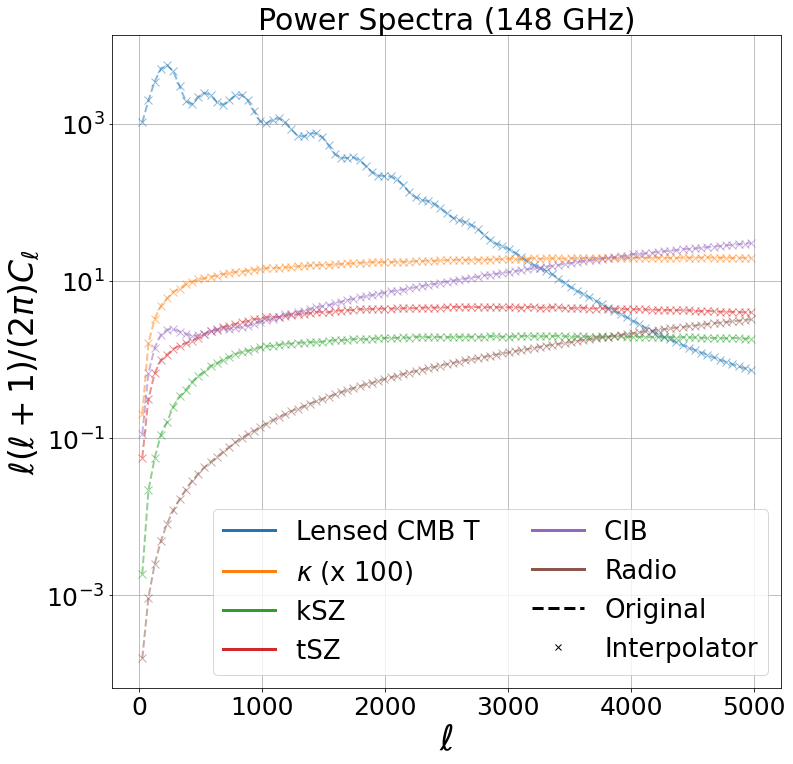

In [9]:
def key2label(key):
    storage = {"kappa":r"$  \kappa$ (x 100)",
               "ksz":"kSZ ",
               "tsz":"tSZ ",
               "ir_pts":"CIB ",
               "rad_pts":"Radio",
               "lensed_cmb_t": "Lensed CMB T"
              }
    return storage[key]

plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
l = np.arange(5000+1)
l_fact = l*(l+1)/(2*np.pi)
for compt_idx in  ["lensed_cmb_t", "kappa", "ksz", "tsz", "ir_pts", "rad_pts"]:
    freq = 148
    multi_fact = 1e4 if compt_idx == "kappa" else 1
 
    color = next(ax._get_lines.prop_cycler)['color']
   
    dl =  specs["ref"][compt_idx]*multi_fact*l_fact
    lbin, dlbin = binner.bin(l, dl)
    plt.plot(lbin, dlbin, alpha=0.5, lw=2, marker="",markersize=3, color=color, ls="--")
    
    dl =  specs["new"][compt_idx]*multi_fact*l_fact
    lbin, dlbin = binner.bin(l, dl)
    plt.plot(lbin, dlbin, alpha=0.5, lw=4, marker="x",markersize=8, color=color, ls="")
    
    plt.plot([],[], lw=3, label=key2label(compt_idx), color=color)


plt.title("Power Spectra (148 GHz)", fontsize=30)
plt.plot([],[], lw=3, marker="", ls="--", label="Original",  color="k")    
plt.plot([],[], lw=3, marker="x", label="Interpolator", color="k", ls="")
ax.set_ylabel(r"$\ell(\ell+1)/(2\pi )C_\ell$", fontsize=33)
ax.set_xlabel(r"$\ell$", fontsize=35)
plt.legend(fontsize=26, ncol=2)

ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
ax.set_yscale("log")
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [19]:
path ='/home/dwhan89/scratch/cosmikyu/output/final_hp'
mmdl_helper = mmDLHelper(path)
mmdl_model = mmDLModel(path)
target_freq = 219
mmdl_model.mmdl_helper.freqs = [30, 90, 148, 277, 350]
interpolator = mmdl_model.get_interpolators(30)

specs_intp = {"ref": {}, "new": {}}
specs_intp["ref"]["l"] = np.arange(5000+1)
specs_intp["new"]["l"] = np.arange(5000+1)

#for compt_idx in ["lensed_cmb_t", "kappa", "ksz"] + mmdl_model.freq_dependent_compts:
for compt_idx in ["lensed_cmb_t", "kappa","ksz" ,"tsz"]:
    print(f"processing {compt_idx}")
    if "cmb" in compt_idx:
        polidx = compt_idx.split("_")[-1].upper()
        temp_idx = "_".join(compt_idx.split("_")[:2])
        nmap = interpolator[f"{compt_idx}"].get_emission(freqs = target_freq*u.GHz)[target_freq]
        nmap = nmap.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(target_freq * u.GHz)).value
        imap =  hp.ud_grade(hp.read_map(mmdl_helper.get_file_name(temp_idx, 30, freq=target_freq, polidx=polidx)), 4096)
    else:
        nmap = interpolator[compt_idx].get_emission(freqs = target_freq*u.GHz)[target_freq]
        if compt_idx != "kappa":
            nmap = nmap.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(target_freq * u.GHz)).value
        imap =  hp.ud_grade(hp.read_map(mmdl_helper.get_file_name(compt_idx, 30, freq=target_freq, polidx=None)), 4096)
    alm_i = hp.map2alm(imap, lmax=5000); del imap
    alm_n = hp.map2alm(nmap, lmax=5000); del nmap
    specs_intp["ref"][compt_idx] = hp.alm2cl(alm_i); del alm_i
    specs_intp["new"][compt_idx] = hp.alm2cl(alm_n); del alm_n
    

processing lensed_cmb_t


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: [WARNING] read_map is override by mmDLInterpolatingComponent
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
processing kappa
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
processing ksz
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
processing tsz
NSIDE = 8192
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


<Figure size 432x288 with 0 Axes>

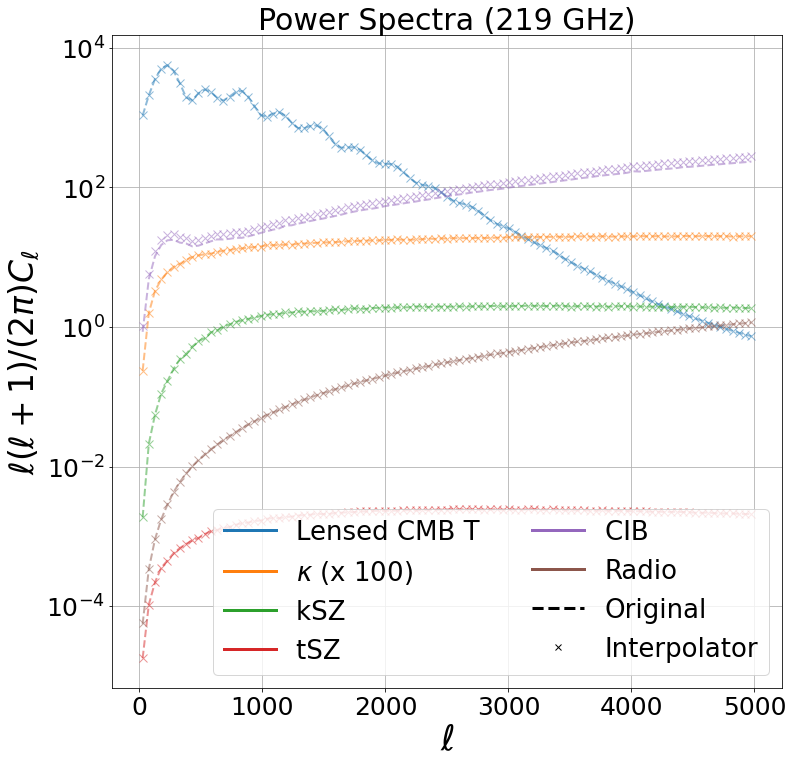

In [22]:
def key2label(key):
    storage = {"kappa":r"$  \kappa$ (x 100)",
               "ksz":"kSZ ",
               "tsz":"tSZ ",
               "ir_pts":"CIB ",
               "rad_pts":"Radio",
               "lensed_cmb_t": "Lensed CMB T"
              }
    return storage[key]

plt.clf()
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
l = np.arange(5000+1)
l_fact = l*(l+1)/(2*np.pi)
for compt_idx in ["lensed_cmb_t", "kappa", "ksz", "tsz", "ir_pts", "rad_pts"]:
    freq = 148
    multi_fact = 1e4 if compt_idx == "kappa" else 1
    
 
    color = next(ax._get_lines.prop_cycler)['color']
   
    dl =  specs_intp["ref"][compt_idx]*multi_fact*l_fact
    lbin, dlbin = binner.bin(l, dl)
    plt.plot(lbin, dlbin, alpha=0.5, lw=2, marker="",markersize=3, color=color, ls="--")
    
    dl =  specs_intp["new"][compt_idx]*multi_fact*l_fact
    lbin, dlbin = binner.bin(l, dl)
    plt.plot(lbin, dlbin, alpha=0.5, lw=4, marker="x",markersize=8, color=color, ls="")
    
    plt.plot([],[], lw=3, label=key2label(compt_idx), color=color)


plt.title(f"Power Spectra ({target_freq} GHz)", fontsize=30)
plt.plot([],[], lw=3, marker="", ls="--", label="Original",  color="k")    
plt.plot([],[], lw=3, marker="x", label="Interpolator", color="k", ls="")
ax.set_ylabel(r"$\ell(\ell+1)/(2\pi )C_\ell$", fontsize=33)
ax.set_xlabel(r"$\ell$", fontsize=35)
plt.legend(fontsize=26, ncol=2)



ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
#ax.axvline(x=200, ls=":", color="k")
ax.set_yscale("log")
ax.grid()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()